In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import special
%matplotlib inline

## Problem 1

In [4]:
def recursive_integrate(func, start, stop, tol=1e-3, conserve_calls=True, old_yvals=None):
    """
    Integrate a real-valued function using a variable step size. Adapted from class.
    
    Parameters
    ----------
    func: callable
        Function to integrate; must take an ndarray as an argument and
        return an ndarray of equal length to the input.
    start: float
        Start of the interval to integrate the function over.
    stop: float
        End of the interval to integrate the function over.
    tol: float, optional
        Maximum allowable error in the approximation of the integral. Default
        is 0.001.
    conserve_calls: bool, optional
        Whether or not to reduce the number of points at which the provided
        function is evaluated.
    yvals: length-3 ndarray, optional
        Not intended for use by the end user; only for reducing the number of
        values at which func is evaluated.
    
    Returns
    -------
    integral: float
        Numerical integral of the input function on the specified domain.
    """
    # Partition the interval into four slices.
    xvals = np.linspace(start, stop, 5)
    width = stop - start
    
    # Only sample points that haven't yet been sampled *if care is desired*
    if old_yvals is None:
        yvals = func(xvals)
    else:
        yvals = np.empty(5)
        yvals[::2] = old_yvals
        yvals[1::2] = func(xvals[1::2])
        
    # Use Simpson's Rule to estimate the integral.
    rough_weights = np.array([1, 4, 1]) / 6
    fine_weights = np.array([1, 4, 2, 4, 1]) / 12
    rough_integral = width * rough_weights @ yvals[::2]
    fine_integral = width * fine_weights @ yvals
    
    # Estimate the error by comparing the rough partition to the finer partition.
    error = np.abs(fine_integral - rough_integral)
    if error < tol:
        return fine_integral
    else:
        # Refine the partition and try again on each resulting half if needed.
        midpoint = 0.5 * (start + stop)
        first_yvals = yvals[:3] if conserve_calls else None
        first_integral = recursive_integrate(
            func, start, midpoint, 0.5 * tol, conserve_calls, first_yvals
        )
        second_yvals = yvals[2:] if conserve_calls else None
        second_integral = recursive_integrate(
            func, midpoint, stop, 0.5 * tol, conserve_calls, second_yvals
        )
        return first_integral + second_integral

The above implementation might not be the best implementation for cutting down on the number of function calls, but it's the fastest of the different implementations I've tried, and also the most compact.

In [5]:
# Test it with something analytic. Let's do 1/x from 1 to 2.
def monomial(x, degree):
    """Evaluate a monomial of a specified degree."""
    return x ** degree

truth = np.log(2)
estimate = recursive_integrate(lambda x: monomial(x, -1), 1, 2)
error = truth - estimate
print(error)

-7.350094585301115e-06


Let's do some timing tests to see if we actually get a speedup from not evaluating the function at points that have already been sampled.

In [68]:
%%timeit
integral = recursive_integrate(lambda x: monomial(x, -1), 1, 10, conserve_calls=False)

556 µs ± 5.75 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [69]:
%%timeit
integral = recursive_integrate(lambda x: monomial(x, -1), 1, 10, conserve_calls=True)

594 µs ± 2.89 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


This suggests that there's actually more computational overhead involved in avoiding repeated function calls than there are savings from the fewer x-values at which the function is evaluated. This might not hold for something more complicated, though. So let's do some exploring with different functions.

In [70]:
%%timeit
integral = recursive_integrate(lambda x: special.airy(x)[0], -10, 10, conserve_calls=False)

3.15 ms ± 72.1 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [71]:
%%timeit
integral = recursive_integrate(lambda x: special.airy(x)[0], -10, 10, conserve_calls=True)

3.48 ms ± 88.5 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


Looks like the airy function evaluation is efficient enough so that reducing the number of points the function is evaluated at does not give us more time than it costs to do the checking for reducing the number of calls.

In [58]:
def clipped_sine(x):
    """Sine clipped to be between -0.5 and 0.5."""
    result = np.sin(x)
    result = np.where(result > 0.5, 0.5, result)
    result = np.where(result < -0.5, -0.5, result)
    return result

In [67]:
%%timeit
integral = recursive_integrate(clipped_sine, -10, 10, conserve_calls=False)

42.9 µs ± 451 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [66]:
%%timeit
integral = recursive_integrate(clipped_sine, -10, 10, conserve_calls=True)

43.1 µs ± 592 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)


Hmmm... Still not complicated enough of a function for us to have an improvement in performance.

It seems like the moral of this story is that reducing the number of points the function is evaluated at does not provide us a performance boost for a large class of functions. I can see this being useful for something where evaluating the function is actually quite expensive&mdash;at least more expensive than creating and filling in a few buffer arrays, along with the extra logic needed to allow for the feature to be easily switched on or off. Either way, let's get an idea of how many computations we save by turning on the feature for not evaluating points we have already sampled.  
  
We always sample the function at least 5 times for the first iteration. Counting is a little tricky here, since this implementation is doubly recursive in a kind of weird way. Let's suppose our first iteration wasn't good enough, so we refine our partition and now calculate two more integrations, each with five sample points. So two iterations in, and we've gone from 5 samples to 15 samples. If we don't resample points that have already been sampled, then we instead have 9 samples, since each new iteration only adds two new points. In fact, each iteration beyond the first adds 10 more sample points if we aren't careful, but only adds 4 more if we are careful. So being careful saves us $6N$ samples of the function if we iterate $N$ times beyond the initial iteration. In other words, if we zero-index our recursion depth, then being careful about resampling saves us $6N$ evaluations of the function for a recursion depth of $N$.

## Problem 2

In [77]:
def build_cheb_basis(xvals, order):
    """
    Build a matrix of Chebyshev basis vectors evaluated at each provided x.
    """
    basis = np.zeros([order + 1, order + 1])
    basis[:,0] = 1
    basis[:,1] = xvals
    for i in range(1, order):
        basis[:, i + 1] = 2 * xvals * basis[:, i] - basis[:, i - 1]
    return basis

def chebyshev_polyfit(func, order=5, start=-1, end=1):
    """
    Fit a function using a Chebyshev polynomial of a given order.
    
    Parameters
    ----------
    func: callable
        Function to be fit by the polynomial.
    order: int, optional
        Highest order term in the fit. Default 5.
        
    Returns
    -------
    coeffs: ndarray
        Coefficients for the best-fit Chebyshev polynomial to the data.
    """
    xvals = np.linspace(start, end, order + 1)
    yvals = func(xvals)
    
    # put an explanatory comment here
    basis = build_cheb_basis(xvals, order)
    coeffs = np.linalg.inv(basis) @ yvals
    return coeffs

In [78]:
coeffs = chebyshev_polyfit(np.log2, order=5, start=0.5)

In [79]:
func = np.cos
coeffs = chebyshev_polyfit(func, order=30)

In [85]:
xvals = np.linspace(-1, 1.0, 1000)
basis = build_cheb_basis(xvals, coeffs.size - 1)
y_true = func(xvals)
y_est = basis @ coeffs

ValueError: could not broadcast input array from shape (1000) into shape (31)

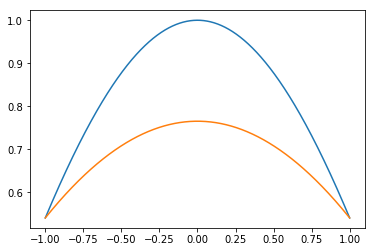

In [74]:
plt.plot(xvals, y_true)
plt.plot(xvals, y_est)

## Problem 3

### Part a

### Part b